In [13]:
import pandas as pd
import pvlib
from pvlib.clearsky import detect_clearsky
import matplotlib.pyplot as plt
import mysql.connector
from sqlalchemy import create_engine
from datetime import datetime, timedelta, date, time
import requests
import geocoder
import json
import math
from collections import Counter
import statistics
import numpy as np

In [14]:
pd.set_option('display.max_rows', 1000)

## Main script

##### Get raw data

In [15]:
lat, long = get_coords('Nickelson 2')

In [ ]:
start = "2020-07-01"
end = '2020-08-01'

In [16]:
data = get_data("nickelson_2", fake_poa=False)

##### Create clearsky model for given lat, long

In [17]:
cs_model = get_cs_model(lat, long, start='2020-07-01', end='2020-07-31')

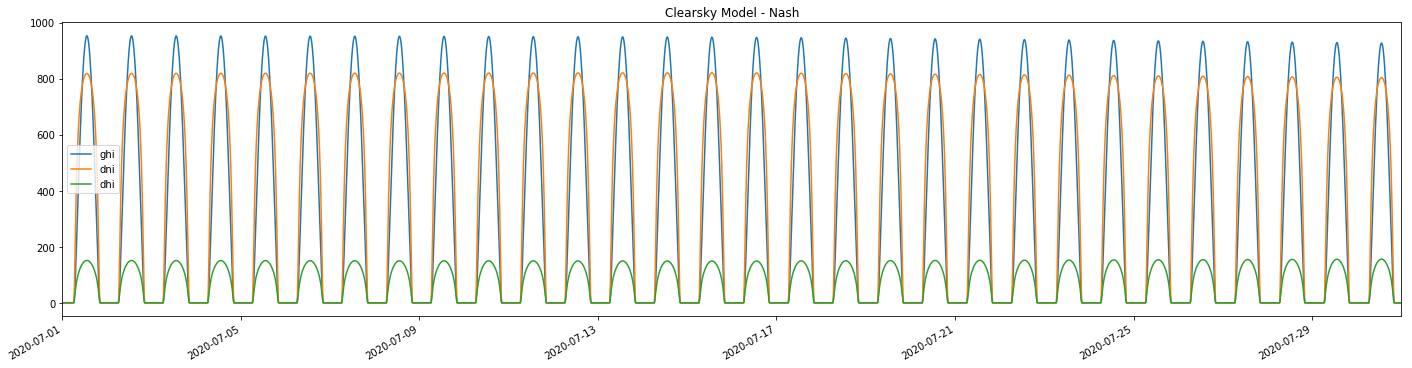

In [18]:
cs_model.plot(figsize=(24, 6), title="Clearsky Model - Nash")

##### Join the raw data and clearsky model

In [19]:
combo = pd.concat([data, cs_model], axis=1, join="inner")

In [20]:
combo.fillna(0, inplace=True)

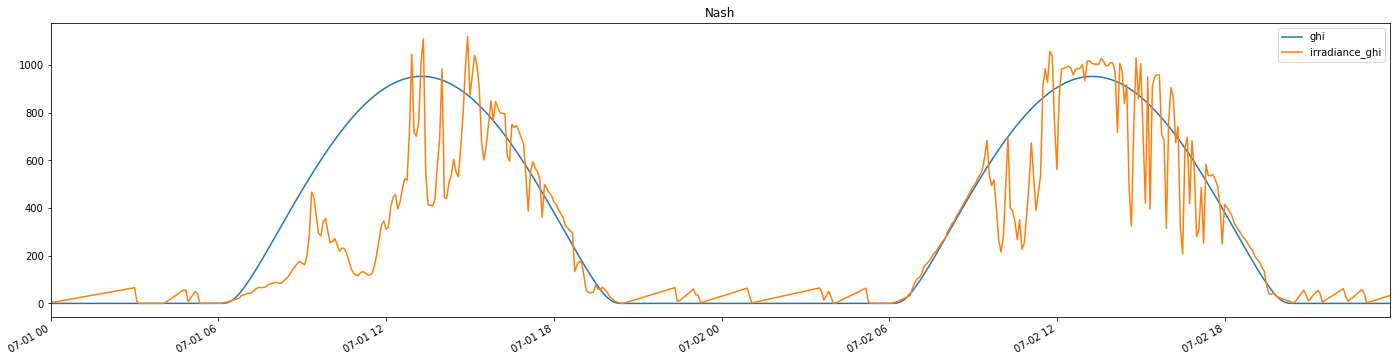

In [21]:
plot_cs(combo, ['ghi', 'irradiance_ghi'], [], start="2020-07-01", dur=2, title="Nash", figsize=(24, 6))

##### Create clearsky flags to signify clearsky periods

In [23]:
cs_df = create_clearsky_flags(combo, 'ghi', 'irradiance_ghi', 15)

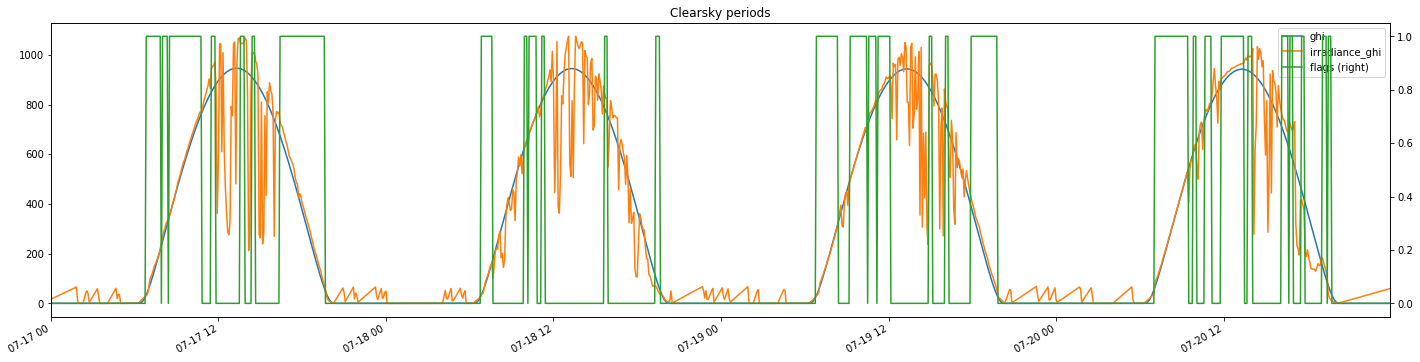

In [24]:
plot_cs(cs_df, ["ghi", "irradiance_ghi"], ["flags"], start="2020-07-17", dur=4, title="Clearsky periods", figsize=(24, 6))

##### Calculate the clearness level each day

In [1576]:
cs_df_clr = calculate_clearness_level(cs_df, "irradiance_ghi", "ghi", with_components=True)
cs_df_clr = filter_diffuse(cs_df_clr, 'Overall Efficiency', 'irradiance_ghi')

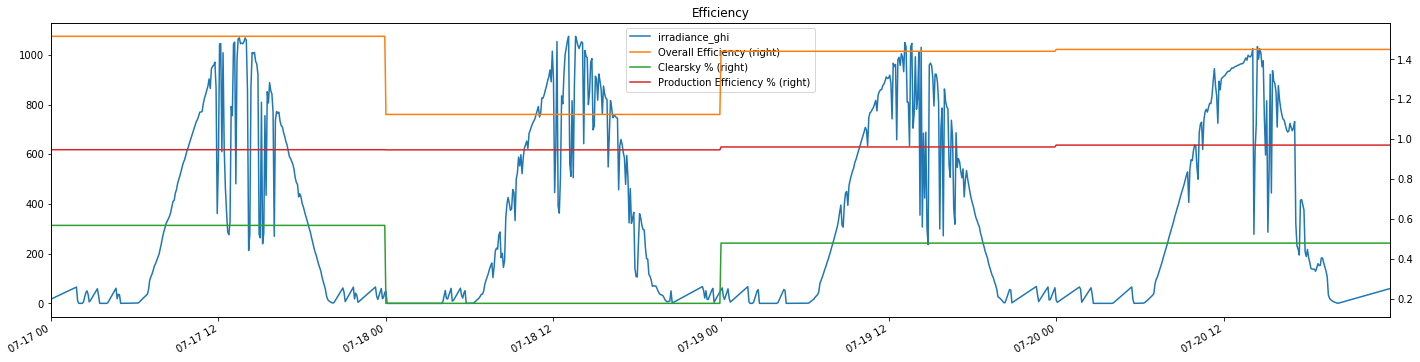

In [1577]:
plot_cs(cs_df_clr, ["irradiance_ghi"], ["Overall Efficiency","Clearsky %", "Production Efficiency %"], start="2020-07-17", dur=4, title="Efficiency", figsize=(24, 6))

##### Find anomalies 

In [1586]:
cs_df_an = create_anomaly_flags(cs_df_clr, normalized_close=True, flag_gradual_shade=True)

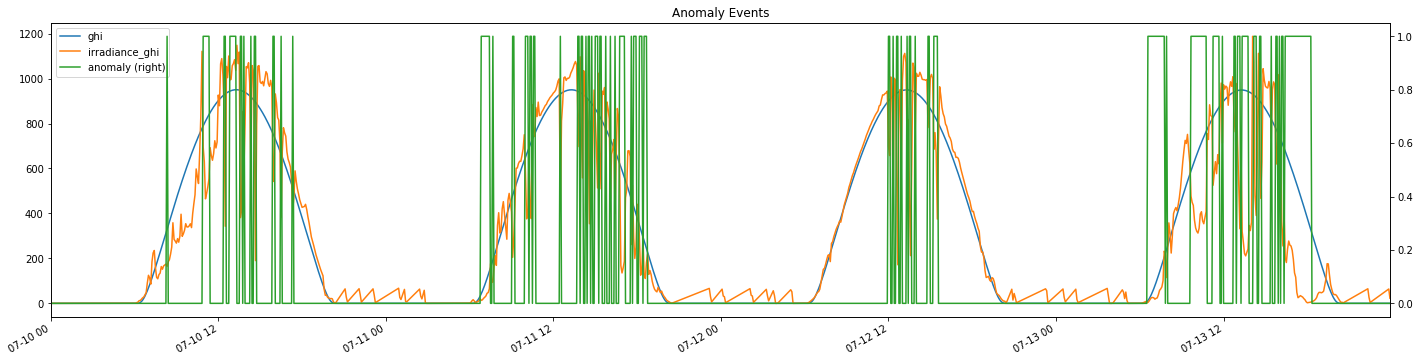

In [1589]:
plot_cs(cs_df_an, ["ghi", "irradiance_ghi"], ["anomaly"], start="2020-07-10", dur=4, title="Anomaly Events", figsize=(24, 6))

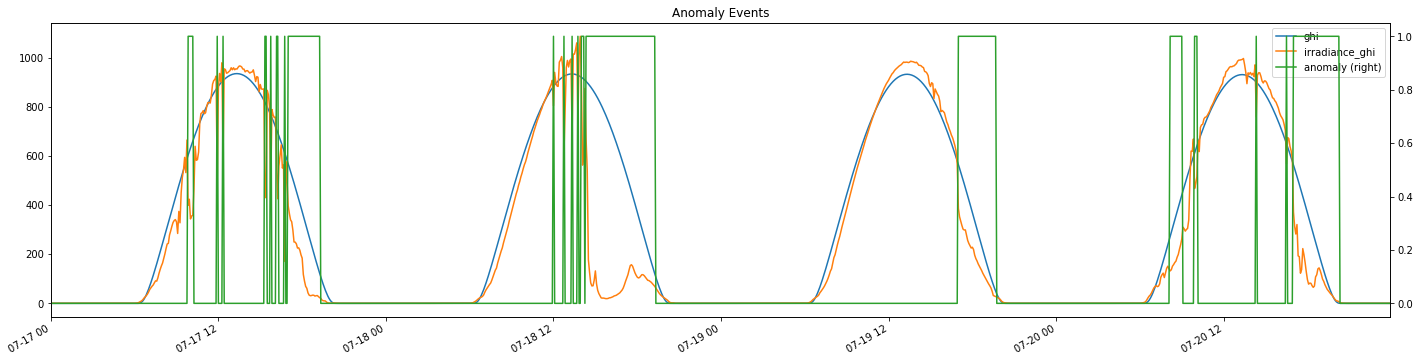

In [1517]:
plot_cs(cs_df_an, ["ghi", "irradiance_ghi"], ["anomaly"], start="2020-07-17", dur=4, title="Anomaly Events", figsize=(24, 6))

##### Identify most common anomaly times

In [1596]:
cs_df_cmn = find_common_anomalies(cs_df_an, "anomaly", force=False, print_measures=True, threshold_percent=0.75)

It is unlikely that there is a shading event in this data.
Standard deviation / mean:  0.31760068510848666
Percent difference between amount of values above and below the mean:  0.018404907975460124
Values greater than 2x the median:  0
Shading flags were added.


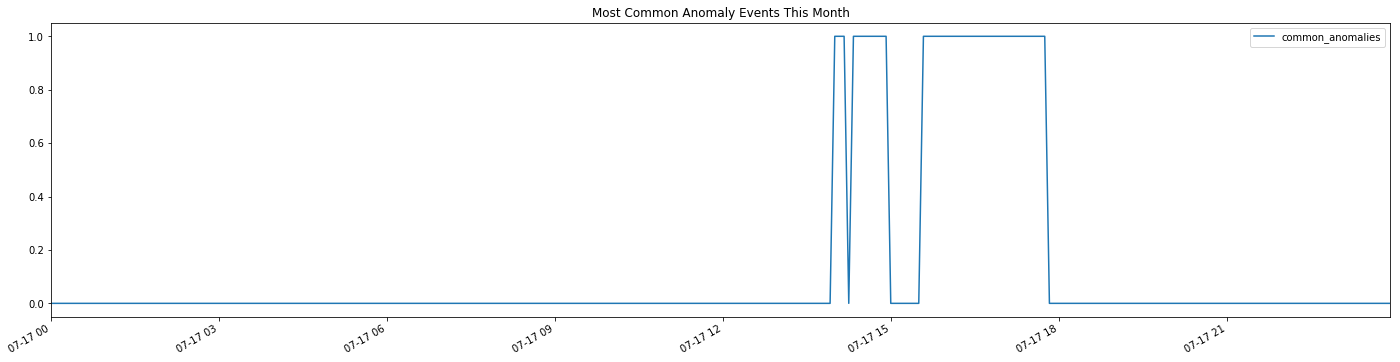

In [1597]:
plot_cs(cs_df_cmn, ["common_anomalies"], [], start="2020-07-17", dur=1, title="Most Common Anomaly Events This Month", figsize=(24, 6))

##### Identify most likely shading events based on anomalies

In [1598]:
cs_df_shd = bitwise_and(cs_df_cmn, 'anomaly', 'common_anomalies', 'shading?')

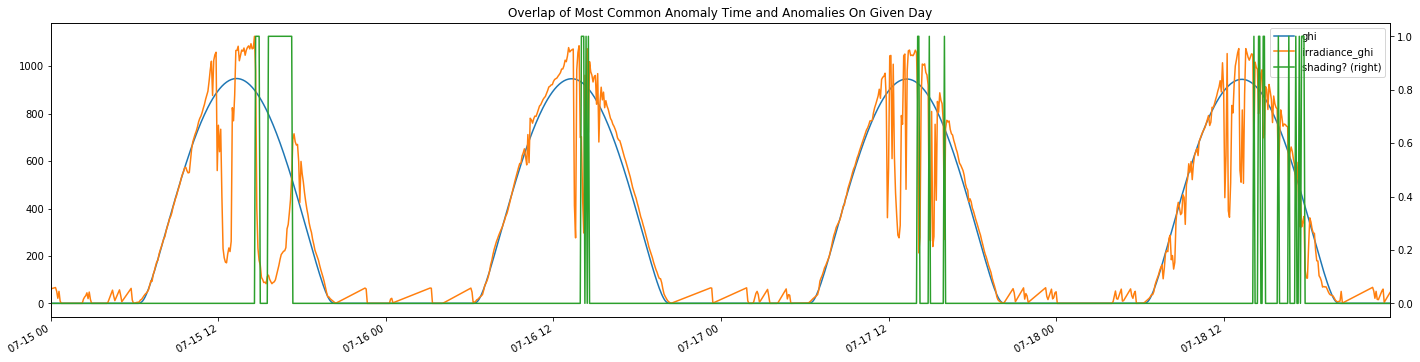

In [1605]:
plot_cs(cs_df_shd, ["ghi", "irradiance_ghi"], ["shading?"], start="2020-07-15", dur=4, title="Overlap of Most Common Anomaly Time and Anomalies On Given Day", figsize=(24, 6))

In [1522]:
quantify_loss(cs_df_shd, "ghi", "irradiance_ghi", "Overall Efficiency", "shading?", 0.8)

(156.66147360492138, 1.95)

##### Filter out diffuse days and keep most clear days

In [1523]:
cs_df_only_clr = filter_diffuse(cs_df_shd, 'Overall Efficiency', 'irradiance_ghi', thresh_p=0.75)

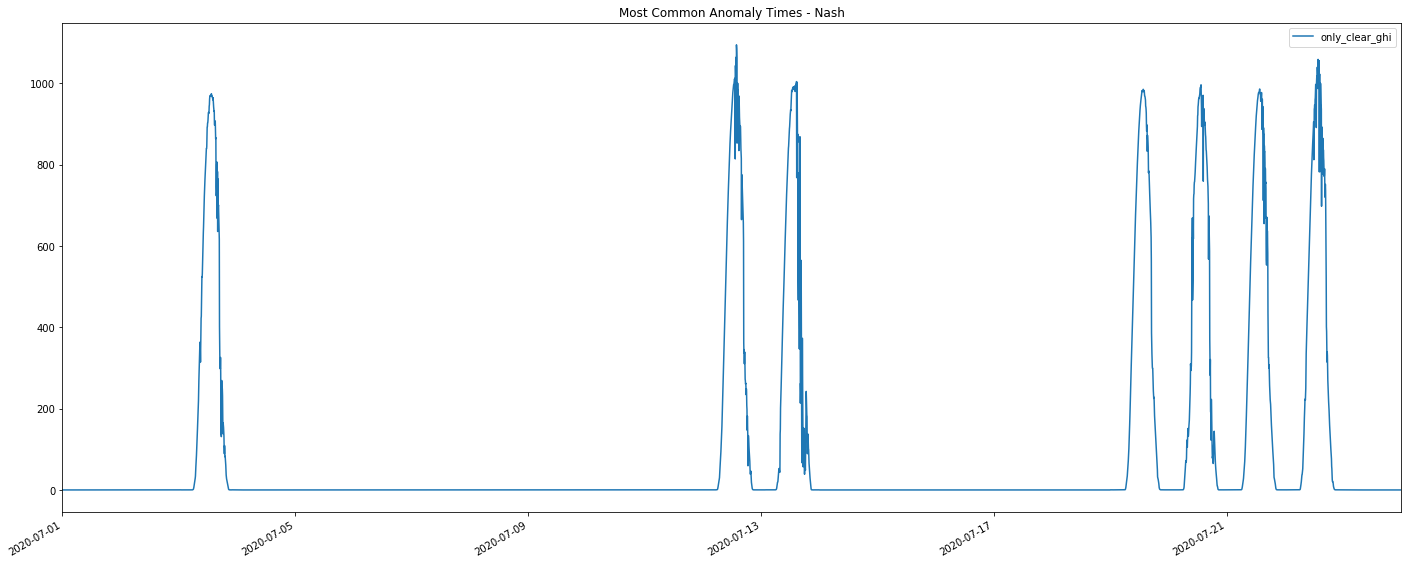

In [1525]:
title = "Most Common Anomaly Times - Nash"
a1 = ["irradiance_ghi", "ghi"]
a2 = ["anomaly"]
a3 = ["common_anomalies"]
a4 = ["Overall Efficiency"]#"Clearsky %", "Production Efficiency %"]
a5 = ['shading?']
a6 = ["only_clear_ghi"]
plot_cs(cs_df_only_clr, a6, [], start="2020-07-01", dur=0, title=title)

## Experiments

- ~~Create clearsky model~~ Sat
- ~~Define and label clearsky periods~~ Sun
- ~~Create anomaly flags~~ Mon
    - ~~Add condition if actual value is certain amount less than clearsky to account for morning (gradual) shading~~ Wed
    - ~~Normalize by adding initial delta to the check condition to account for initial difference~~ Wed
- ~~Determine most common anomaly times~~ Mon
- ~~Set threshold for clearsky days and classify days as clearsky~~ Tue
- ~~Compare best clearsky days with modeled irradiance~~ Tue
- Quantify magnitude of underperformance events
- ~~Estimate loss in irradiance and output due to common anomaly events~~ Tue/Wed
- ~~Find threshold to determine if anomaly events could be shading~~ Wed

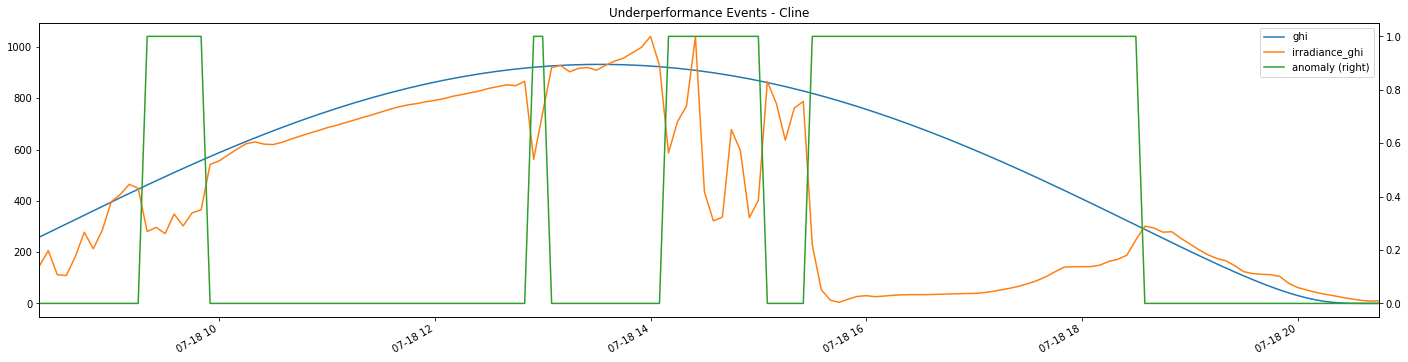

In [463]:
ax = temp[100:250][["ghi", "irradiance_ghi"]].plot(figsize=(24, 6), title="Underperformance Events - Cline")
temp[100:250][["anomaly"]].plot(figsize=(24, 6), secondary_y=True, ax=ax)

## Quantify loss from shading events

In [2]:
def quantify_loss(df, cs_col, ghi_col, eff_col, shade_col, thresh_p=0.75):
    
    #Find resolution in minutes
    resolution = (df[:2].index[1] - df[:2].index[0]).seconds/60
    
    thresh = pd.Series(df[eff_col].unique()).quantile([thresh_p]).values[0]
    
    #Filter only the clearest days
    df = df[df[eff_col] >= thresh]
    #Filter only shading events
    df = df[df[shade_col] == 1]
    
    #Find average W/m^2 loss during shading events
    avg_loss = (df[cs_col].sum() - df[ghi_col].sum()) / len(df)
    #Find average duration of shading events per day
    avg_dur = (((len(df) / len(df.index.day.unique()))-1)*resolution)/60
    
    return avg_loss, avg_dur

## Filter out diffuse days

In [3]:
def filter_diffuse(df, eff_col, irr_col, thresh_p=0.75):
    df = df.copy()
    
    thresh = pd.Series(df[eff_col].unique()).quantile([thresh_p]).values[0]
    if thresh > 1.4:
        thresh = 1.4
    
    df["only_clear_ghi"] = df[irr_col]
    df.loc[df[eff_col] < thresh, 'only_clear_ghi'] = 0
    
    return df

## Calculate clearness day by day

In [4]:
def bitwise_and(df, col1, col2, new_col):
    df = df.copy()
    df[new_col] = list(map(lambda x, y: x and y, df[col1].values, df[col2].values))
    return df

In [5]:
def calculate_clearness_level(df, actual_col, clearsky_col, with_components=False):
    df=df.copy()
    
    production_hours = df[df["ghi"] > 1]
    grouper = production_hours.groupby(pd.Grouper(freq='D'))
    grouper_sum = grouper.sum()
    
    count = grouper.count().iloc[0][0]
    efficiencies = grouper_sum[actual_col] / grouper_sum[clearsky_col]
    efficiencies.name = "Production Efficiency"
    
    clearsky_value = grouper_sum['flags'] / count
    
    combined = (efficiencies + clearsky_value)
    combined.name = "Clearsky Value"
    
    #clearest_days = combined[combined > combined.quantile([.75]).values[0]]
    
    df['Overall Efficiency'] = 0
    if with_components:
        df['Clearsky %'] = 0
        df['Production Efficiency'] = 0
    for day, value in combined.items():
        df.at[day.date():day.date() + timedelta(days=1), 'Overall Efficiency'] = value
        if with_components:
            cs = clearsky_value[day]
            eff = efficiencies[day]
            df.at[day.date():day.date() + timedelta(days=1), 'Clearsky %'] = cs
            df.at[day.date():day.date() + timedelta(days=1), 'Production Efficiency %'] = eff
        
    return df

## Find most common anomaly times

In [6]:
def find_common_anomalies(df, anomaly_column, threshold_percent=None, force=False, print_measures=False):
    df = df.copy()

    anomaly_times = df[df[anomaly_column] == 1].index.time
    cnt = Counter(anomaly_times)

    anomaly_dict = pd.DataFrame.from_dict(cnt.items()).sort_values(0)
    anomaly_dict.set_index(0, inplace=True)
    rolling_vals = {}
    for idx, row in anomaly_dict.iterrows():
        rolling_window = anomaly_dict[idx:(datetime.combine(date.today(), idx) + timedelta(minutes=30)).time()]
        total = sum(rolling_window[1])
        rolling_vals[idx] = total

    counts = pd.DataFrame.from_dict(rolling_vals.items()).sort_values(1, ascending=False)
    
    #Perform analysis on counts
    shading_flag = 0
    counts_col = counts[1]
    std = np.std(counts_col)
    mean = np.mean(counts_col)
    median = np.median(counts_col)
    shading_warning = {
        0: "unlikely",
        1: "possible",
        2: "likely",
        3: "very likely"
    }
    
    #If the stdev is suspiciously high, meaning there are outliers that could indicate shading
    if std/mean > 0.6:
        shading_flag+=1
    
    #Calculate percent diff in amounts above and below mean to identify a skew which could mean shading events
    x = len(counts_col[counts_col > mean])
    y = len(counts_col[counts_col < mean])
    diff = abs(x-y) / (x+y)
    if diff > 0.2:
        shading_flag+=1
    
    #Find values greater than twice the median which should identify larger values that are more likely to be shading
    suspicious_values = counts[counts[1] > 2*median]
    if len(suspicious_values) > 5:
        shading_flag+=1
        
    print("It is " + shading_warning[shading_flag] + " that there is a shading event in this data.")
    if print_measures:
        print("Standard deviation / mean: ", std/mean)
        print("Percent difference between amount of values above and below the mean: ", diff)
        print("Values greater than 2x the median: ", len(suspicious_values))
    
    #Determine if and how to select common shade times
    if threshold_percent:
        threshold = counts[1].quantile([threshold_percent]).values[0]
        common_anomaly_times = counts[counts[1] > threshold].set_index(0).to_dict()[1]
    elif shading_flag > 0 or force:
        common_anomaly_times = suspicious_values.set_index(0).to_dict()[1]
    else:
        print("Shading flags were not added. Specify a threshold percentage to force flags.")
        return df
        
    most_common_flags = []
    for time in df.index:
        if time.time() in common_anomaly_times:
            most_common_flags.append(1)
        else:
            most_common_flags.append(0)

    df['common_anomalies'] = most_common_flags
    print("Shading flags were added.")
    
    return df

## Create anomaly flags

In [7]:
def create_anomaly_flags(df, delta_percent=0.15, normalized_close=True, flag_gradual_shade=False, morningtime=11):
    df = df.copy()
    max_irr = 666.67#df["irradiance_ghi"].max()
    event_flags = [0]
    
    previous_event = {}
    previous_cs = df.iloc[0]["ghi"]
    previous = df.iloc[0]["irradiance_ghi"]
    
    for df_index, df_row in df[1:].iterrows():
        index, cs, current = df_index, df_row["ghi"], df_row["irradiance_ghi"]
        
        #Skip values that signify non-production hours
        if cs < 5 or previous_cs < 5: #Removed condition to check if current/previous also less than 5
            previous_event = {}
            event_flags.append(0)
            previous=current
            previous_cs=cs
            continue
                    
        #Find the deltas
        delta = abs(previous - current)
        
        #Find value delta direction
        delta_change="neg"
        if previous-current < 0:
            delta_change = "pos"
        
        #Determine whether an event is eligible for closing by proximity to clearsky value
        if previous_event and not previous_event["Consider Close"]:
            if delta_change != previous_event["Delta Change"]:
                previous_event["Consider Close"] = True
                
        #Close event conditions
        if previous_event and previous_event["Consider Close"]:
            thresh = cs*0.1
            if normalized_close:
                thresh+=previous_event["CS Delta"]
            if abs(current-cs) < thresh:
                previous_event = {}
        
        #Create event
        event = {
            "Delta": delta,
            "Delta Change": delta_change,
            "Value": previous,
            "Clearsky": previous_cs,
            "CS Delta": previous_cs-previous,
            "Consider Close": False
        }
        
        #If there is a significant spike
        if delta > delta_percent*max_irr:
                
            #If an event is open
            if previous_event:
                if previous_event["Delta Change"] == delta_change: #Skip if changes in the same direction
                    #print("Skipping: Same direction delta")
                    pass
                else:
                    #print("Closing event")
                    previous_event = {}
            #If no event is open
            else:
                #Only create events for icicles, not spikes
                if delta_change == "neg":
                    #print("Creating event ", index, " with CS Delta ", previous_cs-previous)
                    previous_event = event
                    
        if flag_gradual_shade and index.time() <= time(hour=morningtime) and not previous_event and current < 0.5*cs:
            event["Consider Close"] = True
            previous_event = event
        
        #Add flag according to open event
        if previous_event:
            event_flags.append(1)
        else:
            event_flags.append(0)
            
        previous=current
        previous_cs=cs
    
    df['anomaly'] = event_flags
    return df

## Plotting

In [8]:
def plot_cs(df, main_col, against_col, start="2020-07-01", dur=4, title=None, figsize=(24, 10)):
    
    if dur:
        dur = dur-1
        end = (datetime.strptime(start, "%Y-%m-%d") + timedelta(days=dur)).strftime("%Y-%m-%d")
        temp = df[start:end]
    else:
        temp = df[start:]
    
    ax = temp[main_col].plot(figsize=figsize, title=title)
    if against_col:
        temp[against_col].plot(figsize=figsize, secondary_y=True, ax=ax)
    ax.plot

## Create clearsky flags

In [9]:
def create_clearsky_flags(df, actual_col, clearsky_col, window, output_flag_col='flags'):
    df = df.copy()
    clearsky = detect_clearsky(df[actual_col], 
                                df[clearsky_col], 
                                df.index,
                                window)
                                #mean_diff=200, 
                                #max_diff=500,
                                #lower_line_length=-20,
                                #upper_line_length=20,
                                #var_diff=0.7)
                                #slope_dev=20)
    #clearsky_df = pd.DataFrame(clearsky)
    flags = [1 if x else 0 for x in clearsky.values]
    
    df[output_flag_col] = flags
    
    return df

## Clearsky Modeling

In [10]:
def get_cs_model(lat, long, start='2020-01-01', end='2020-02-01'):
    url = 'https://api.opentopodata.org/v1/srtm30m?locations={},{}'.format(lat, long)
    response = requests.get(url)
    elevation = json.loads(response.text)['results'][0]['elevation']
    
    tus = pvlib.location.Location(lat, long, 'US/Eastern', elevation, 'Cline')
    times = pd.date_range(start=start, end=end, freq='5min', tz=tus.tz)
    
    cs = tus.get_clearsky(times, model='ineichen')
    
    cs.fillna(0, inplace=True)
    
    return cs

## Get site list

In [11]:
def get_coords(site):

    db_t = 'arevon-drive'
    engine = create_engine('mysql+mysqlconnector://legolis658@arevon-1:1Midlearth658!@arevon-1.mysql.database.azure.com:3306/' + db_t, echo=False)
    data = pd.read_sql_query(sql='SELECT * FROM `' + db_t + "`.sitelist", con=engine)

    data.set_index('ProjectName', inplace=True)

    lat = data.loc[site]['Latitude']
    long = data.loc[site]['Longitude']
    
    return lat, long

## Get the actual data

In [12]:
def get_data(plant="cline", grouping="5min", fake_poa=False):
    tz = 'US/Eastern'
    device="pyranometer_ghi"
    if fake_poa:
        device="pyranometer_poa"
    engine = create_engine('mysql+mysqlconnector://legolis658@arevon-1:1Midlearth658!@arevon-1.mysql.database.azure.com:3306/' + plant, echo=False)
    data = pd.read_sql_query(sql='SELECT * FROM `' + plant + "`." + device + " WHERE Timestamp > '2020-01-01'", con=engine)
 
    localized_dt_index = pd.DatetimeIndex(data['Timestamp']).tz_localize('UTC')
    localized_dt_index = localized_dt_index.tz_convert(tz)
    data["Timestamp"] = localized_dt_index

    data_grouped = data.groupby(pd.Grouper(key='Timestamp', freq=grouping, label='right', closed='right')).mean()
    
    if fake_poa:
        data_grouped.rename({'irradiance_poa': 'irradiance_ghi'}, axis=1, inplace=True)
    
    return data_grouped